# Requirements

In [25]:
import matplotlib.pyplot as plt

# Problem setting

Some deterministic functions will have a periodic behavior with a certain length, but only reach this periodic mode after a certain number of evaluations called the offset.

First, consider an example, the Collatz conjecture.  This function is defined as:
$$
    f(n) = \begin{cases}
               n/2 & \text{if $n$ is even} \\
               3n + 1 & \text{if $n$ is odd}
           \end{cases}
$$
Collatz conjecture says this function will always reach a cycle $\ldots,4, 2, 1, 4, 2, 1, \ldots$.  If the Collatz conjecture is true, the cycle length is always 4.  However, the offset depends on the starting value of $n$.

For example, for a starting value of $n = 5$, you would get $16, 8, 4, 2, 1, 4, 2, 1, \ldots$, so the offset would be 3.  On the other hand, for $n = 7$ the sequence would be $22, 11, 34, 17, 52, 26, 13, 40, 20, 10, 5, 16, 8, 4, 2, 1, 4, 2, 1, \ldots$.  Hence the offset is 14.

In [1]:
def collatz_conjecture(n):
    return n//2 if n % 2 == 0 else 3*n + 1

In [2]:
n = 5
for i in range(10):
    n = collatz_conjecture(n)
    print(f'{i + 1:3} -> {n}')

  1 -> 16
  2 -> 8
  3 -> 4
  4 -> 2
  5 -> 1
  6 -> 4
  7 -> 2
  8 -> 1
  9 -> 4
 10 -> 2


In [3]:
n = 7
for i in range(20):
    n = collatz_conjecture(n)
    print(f'{i + 1:3} -> {n}')

  1 -> 22
  2 -> 11
  3 -> 34
  4 -> 17
  5 -> 52
  6 -> 26
  7 -> 13
  8 -> 40
  9 -> 20
 10 -> 10
 11 -> 5
 12 -> 16
 13 -> 8
 14 -> 4
 15 -> 2
 16 -> 1
 17 -> 4
 18 -> 2
 19 -> 1
 20 -> 4


# Finding cycles

Finding cycles in the evolution of a deterministic function can be done in many ways.

## Naive approach

The most naive approach is to store the subsequent values in a list, and at each iteration check whether the current value occurs in that list.  If so, it is easy to determine the offset and the cycle length.

In [13]:
def find_cycles_naive(func, start_value, max_iters):
    history = [start_value]
    for generation in range(1, 1 + max_iters):
        value = func(history[-1])
        if value in history:
            offset = history.index(value)
            return offset, generation - offset
        else:
            history.append(value)
    return max_iters, None

In [14]:
find_cycles_naive(collatz_conjecture, 5, 100)

(3, 3)

In [15]:
find_cycles_naive(collatz_conjecture, 7, 100)

(14, 3)

## Dictionary

A better approach is to store the function values as keys in a dictionary, and the corresponding iteration as value.

In [16]:
def find_cycles_dict(func, start_value, max_iters):
    history = {start_value: 0}
    value = start_value
    for generation in range(1, 1 + max_iters):
        value = func(value)
        if value in history:
            offset = history[value]
            return offset, generation - offset
        else:
            history[value] = generation
    return max_iters, None

In [17]:
find_cycles_dict(collatz_conjecture, 7, 100)

(14, 3)

## Floyd's cycle detection algorithm

Floyd's algorithm trades execution time for memory usage.  It will be useful when the cost to store consecutive states of the function grows too large.

In [1]:
def find_cycles_floyd(func, start_value, max_iters):
    tortoise = func(start_value)
    hare = func(tortoise)
    while tortoise != hare:
        tortoise = func(tortoise)
        hare = func(func(hare))
    offset = 0
    tortoise = start_value
    while tortoise != hare:
        tortoise = func(tortoise)
        hare = func(hare)
        offset += 1
    length = 1
    hare = func(tortoise)
    while tortoise != hare:
        hare = func(hare)
        length += 1
    return offset, length

In [19]:
find_cycles_floyd(collatz_conjecture, 7, 100)

(14, 3)

# Verification

All three implementations should yield the same results.

In [20]:
for n in range(1024):
    naive_cycle = find_cycles_naive(collatz_conjecture, n, 100_000)
    dict_cycle = find_cycles_dict(collatz_conjecture, n, 100_000)
    floyd_cycle = find_cycles_floyd(collatz_conjecture, n, 100_000)
    assert naive_cycle == dict_cycle
    assert dict_cycle == floyd_cycle

# Timings

It turns out that the dictionary approach has the best performance.

In [21]:
%timeit find_cycles_naive(collatz_conjecture, 1023, 100_000)

15 µs ± 135 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [22]:
%timeit find_cycles_dict(collatz_conjecture, 1023, 100_000)

5.74 µs ± 81.2 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [23]:
%timeit find_cycles_floyd(collatz_conjecture, 1023, 100_000)

13.8 µs ± 168 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [33]:
offsets = [find_cycles_dict(collatz_conjecture, n, 100_000)[0] for n in range(2**8)]

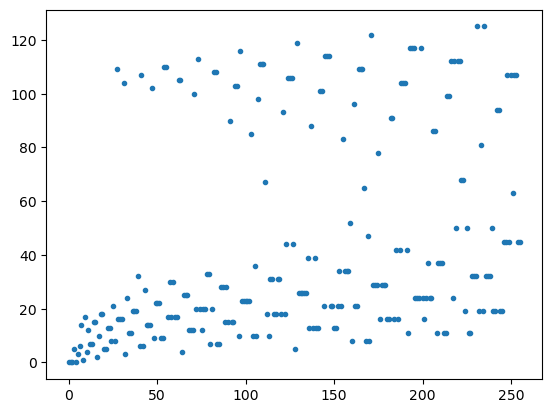

In [34]:
plt.plot(list(range(2**8)), offsets, '.');

In [69]:
def show_series(func, start_value, max_iters):
    value = start_value
    for _ in range(max_iters):
        print(value)
        value = func(value)

To better test and time the implmentations, you can define a function that generates functions with a given offset and cycle length.

In [2]:
def generate_periodic_function(offset, length):
    def internal(n):
        if n < offset - 1:
            return n + 1
        return offset + ((n + 1 - offset) % length)
    return internal

In [51]:
f = generate_periodic_function(5, 3)

In [52]:
for n in range(20):
    print(f(n))

1
2
3
4
5
6
7
5
6
7
5
6
7
5
6
7
5
6
7
5


In [53]:
find_cycles_dict(f, 0, 100)

(5, 3)

In [37]:
for offset in range(1_000):
    for length in range(1, 50):
        f = generate_periodic_function(offset, length)
        assert (offset, length) == find_cycles_floyd(f, 0, 0)

In [38]:
f = generate_periodic_function(10_000, 10_000)

In [39]:
%timeit find_cycles_naive(f, 0, 50_000)

996 ms ± 15.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [40]:
%timeit find_cycles_dict(f, 0, 50_000)

2.23 ms ± 48.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [41]:
%timeit find_cycles_floyd(f, 0, 0)

4.52 ms ± 73 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
